# Finding Stars in Astronomical Images

In this notebook, we study the shape of stars in an astronomical image and think about algorithms that can find the positions of those stars.

The stars are regions of high-intensity on a noisy background.

We will utilize the numpy and scipy package for data analysis.  We will use the matplotlib package to display data.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

Let's use the code from last time to simulate an astronomical image and look at some stars.

Remember!  This version returns simulated images AND the "data" used to generate them.  For the labs, you will not have access to the generating data.  You will have to solve for that.  Use the help command to see how the simulator works:

In [2]:
from simulate_image import imsim
help(imsim)

Help on function imsim in module simulate_image:

imsim(sigma=2.0, RN=10.0, sky_lev=1000.0, add_stars=True, calibrated=True, verbose=False)
    generate astronomical images, potentially with stars (add_stars=True)
    
    calibrated=False means image is uncorrected for flat and dark, to estimate these:
      bias images: set sky_lev=0.,add_stars=False
      flat images: set sky_lev large, add_stars=False
    
    sigma: rms width of stars in pixels
    RN: rms read noise
    sky_lev: sky background counts level



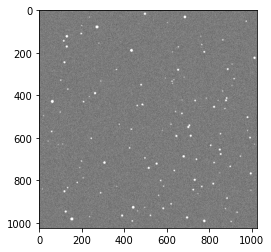

In [3]:
im,data = imsim()
im -= np.median(im)
rms = 1.48*np.median(np.abs(im))
plt.imshow(im.clip(-5*rms,5*rms),cmap='gray')

Here we created an image with stars, and we subtracted away the median signal level in the background.  The image has a background noise level of rms, and we used that to make a properly scaled plot.  

In [4]:
print (data.shape)

(3, 125)


The second numpy array returned by imsim contains the true position of the stars.  data[0] are the x-positions.  data[1] are the y-positions.  data[2] is the integrated signal within the star.  Let's use slicing to zoom-in on one of the stars.

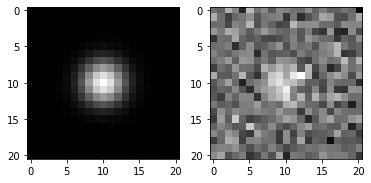

In [5]:
k=data[2].argmax()
i0,j0 = int(data[0,k]), int(data[1,k])
im_thumb_bright = im[i0-10:i0+11,j0-10:j0+11]
k1=data[2].argmin()
i1,j1 = int(data[0,k1]), int(data[1,k1])
im_thumb_faint = im[i1-10:i1+11,j1-10:j1+11]
f,ax = plt.subplots(1,2)
ax[0].imshow(im_thumb_bright,cmap='gray')
ax[1].imshow(im_thumb_faint,cmap='gray')

Here, we use slicing to create an image thumbnail centered on two (the brightest and faintest) stars.  The faint star is barely visible due to all the noise.  We can also plot the profile of the stars in the x and y directions by using the mean method for numpy arrays.

Text(0.5, 0, 'Y position')

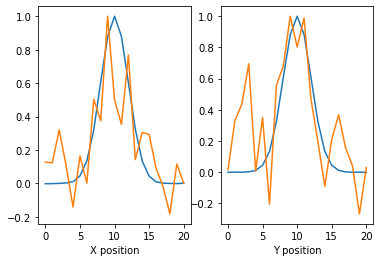

In [6]:
imx = im_thumb_bright.mean(axis=1)
imy = im_thumb_bright.mean(axis=0)
imx1 = im_thumb_faint.mean(axis=1)
imy1 = im_thumb_faint.mean(axis=0)
f,ax = plt.subplots(1,2)
ax[0].plot(imx/imx.max()); ax[0].plot(imx1/imx1.max())
ax[1].plot(imy/imy.max()); ax[1].plot(imy1/imy1.max())
ax[0].set_xlabel("X position")
ax[1].set_xlabel("Y position")

Here, the max() method is used to normalize each profile to a peak of one.  Notice that the star has width of about 4 pixels.  This is because the stars were simulated using a Gaussian function profile with a width parameter of 2 pixels.  For fainter stars, you can see how jagged the curves are; this is because of the noise in the image.  Real-world images have similar noise.  This is what makes star finding difficult!

## Creating an Algorithm to Find All the Stars

In general, we won't know the positions of the stars in the image in advance.  A telescope pointed toward some direction of the sky may find new stars!

How can we go about writing an algorithm to find stars for us?  Let's try something simple to find the bright star first.

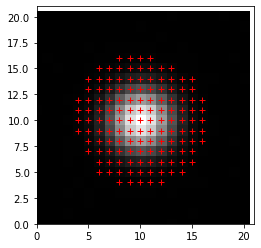

In [7]:
i,j = np.where(im > 5*rms)
plt.imshow(im_thumb_bright.T,cmap='gray')
plt.xlim((0,21))
plt.ylim((0,21))
plt.plot (i-i0+10,j-j0+10,'r+')

Well, we found our star.  But we found it too many times!  We need to dump the overlaps.

In [8]:
candidates = (i>i0-3)*(i<i0+4)*(j>j0-3)*(j<j0+4)
best = im[i[candidates],j[candidates]] == im_thumb_bright.max()
k = np.where(candidates)[0][best]
print (k)

[247]


That's the one we want!

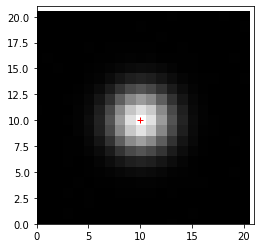

In [9]:
plt.imshow(im_thumb_bright.T,cmap='gray')
plt.xlim((0,21))
plt.ylim((0,21))
plt.plot (i[k]-i0+10,j[k]-j0+10,'r+')

So,to find all the stars.  We will need to dump overlaps like this around each and every candidate position.

Also, you can improve your star finder code by first filtering your image to reduce noise.  There are a number of handy filters in <A HREF="https://docs.scipy.org/doc/scipy/reference/ndimage.html"> scipy.ndimage</A>.  Check 'em out.

You can then take the selection line above (i,j = np.where(im > 5*rms)), and replace im with filtered_im.  This will allow you to use a value smaller than 5, finding more stars.